In [1]:
import pyNUISANCE as pn

Load in some NuWro Events to play with

In [2]:
gevs = pn.EventSource("../q0q3plots/NuWro.numu.numu_flux.flux_dune_neutrino_ND.1203.evts.root")

gri = gevs.run_info()

# Projections

Here we define some projections that we might use for analysis

In [3]:
from pyProSelecta import event, part, unit, pdg, energy, kinetic_energy
from pyNuHepMC import EventUtils
from pyHepMC3.pyHepMC3.HepMC3 import FourVector

def invariant_hadronic_mass(ev):
    # get the hard scatter vertex
    pv = EventUtils.GetPrimaryVertex(ev)
    p4 = FourVector(0,0,0,0)
    # sum all non lepton out-going particles
    for p in pv.particles_out():
        pid_abs = abs(p.pid())
        if (pid_abs > 16) and (pid_abs < 1000000000):
            p4 = p4 + p.momentum()
    return p4.m() / unit.GeV_c2

def EHadAv_Mnv(ev):
    erec = 0
    for fsp in event.all_out_part(ev):
        pid = fsp.pid()

        if abs(pid) == 13:
            continue
        elif pid == 2112:
            continue
        elif pid == 2212 or abs(pid) == 211:
            erec += kinetic_energy(fsp)
        elif pid == 111 or abs(pid) == 11 or pid == 22:
            erec += energy(fsp)
    return erec / unit.GeV

# Analysis Frame

Here we build a data frame of CC events. We can add new columns from combinations of columns defined below with pandas, so don't need to calculate every composite value we might need

In [4]:
wnf5_disp = pn.Prob3plusplusWeightCalc()
wnf5_disp.set_parameters({"baseline_km": 1300, "NuFit:5.2": 1, "osc:numu_disp":1})

evf = pn.EventFrameGen(gevs).filter(pn.pps.ext.isCC) \
    .add_column("enu",pn.pps.ext.enu_GeV) \
    .add_int_column("topo",pn.pps.ext.final_state_topology) \
    .add_column("q0",pn.pps.ext.q0lep_GeV) \
    .add_column("q3",pn.pps.ext.q3lep_GeV) \
    .add_column("W",invariant_hadronic_mass) \
    .add_column("plep",pn.pps.ext.plep_GeV) \
    .add_column("EHadAv_Mnv",EHadAv_Mnv) \
    .add_column("wosc", wnf5_disp.calc_weight)

topo_labels = [ "CC0Pi",
    "NC0Pi",
    "CC1Pi",
    "NC1Pi",
    "CCMultiPi",
    "NCMultiPi" ]

Only Concrete Python instances allowed as dict inputs to YAML conversion!


In [5]:
efa = evf.firstArrow(int(1E6))

Use pandas to add some composite columns

In [6]:
import pandas as pd

pd.options.mode.copy_on_write = True

df = efa.to_pandas()

df["ERec"] = df["plep"] + df["EHadAv_Mnv"]

# cut out events that wont enter the analysis
df = df[df["ERec"] < 6]

df["YRec"] = df["EHadAv_Mnv"]/df["ERec"]
df["ERecMissed"] = (df["ERec"] - df["enu"])
df["ERecBias"] = df["ERecMissed"]/df["enu"]

df

,event.number,weight.cv,fatx_per_sumw.pb_per_target.estimate,fatx_per_sumw.pb_per_nucleon.estimate,process.id,enu,topo,q0,q3,W,plep,EHadAv_Mnv,wosc,ERec,YRec,ERecMissed,ERecBias
5,7,1.0,6.948408e-02,5.790340e-03,600,4.428937,2,3.231451,3.677136,2.176015,1.192815,2.523430,0.350898,3.716245,0.679027,-0.712692,-0.160917
7,9,1.0,5.558726e-02,4.632272e-03,500,2.795027,2,1.441489,1.963942,1.304047,1.349408,1.393553,0.016212,2.742961,0.508047,-0.052067,-0.018628
8,12,1.0,4.275943e-02,3.563286e-03,300,2.598061,0,0.546930,0.905409,2.273883,2.048408,0.438915,0.012332,2.487323,0.176461,-0.110738,-0.042623
9,13,1.0,3.970519e-02,3.308766e-03,400,3.146805,0,0.706227,0.898746,1.374674,2.438290,0.653080,0.067379,3.091369,0.211259,-0.055436,-0.017617
10,14,1.0,3.705817e-02,3.088181e-03,600,5.904933,4,4.393155,4.694525,2.435399,1.508082,3.799000,0.581567,5.307082,0.715836,-0.597851,-0.101246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745225,999973,1.0,5.558871e-07,4.632392e-08,400,1.062748,2,0.561350,0.942154,1.216885,0.490139,0.233056,0.491653,0.723195,0.322259,-0.339553,-0.319504
745230,999978,1.0,5.558843e-07,4.632369e-08,500,3.218134,-1,1.550063,1.794878,1.559174,1.664722,1.491231,0.081680,3.155952,0.472514,-0.062182,-0.019322
745233,999984,1.0,5.558810e-07,4.632341e-08,200,3.414840,2,0.950818,1.600283,0.938272,2.461756,0.671868,0.124518,3.133624,0.214406,-0.281217,-0.082351
745235,999986,1.0,5.558798e-07,4.632332e-08,600,2.822932,2,2.292094,2.786991,1.638997,0.520217,1.761934,0.018588,2.282151,0.772050,-0.540781,-0.191567


In [7]:
import pyarrow as pa

#convert the pandas object back to an arrow table for onwards processing.

ef = pa.Table.from_pandas(df)

In [8]:
gnorm = gevs.norm_info(pn.nhm.FATXUtils.cm2ten38_PerNucleon)
print(f"NuWro FATX = {gnorm.fatx} cm^2 10^-38 /N")

NuWro FATX = 4.632271844767111 cm^2 10^-38 /N


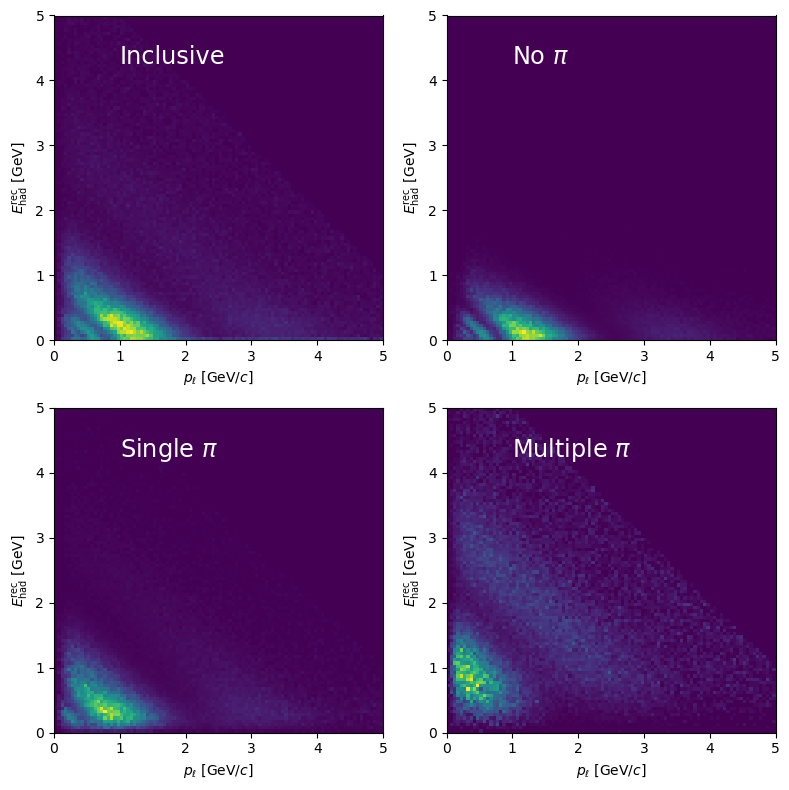

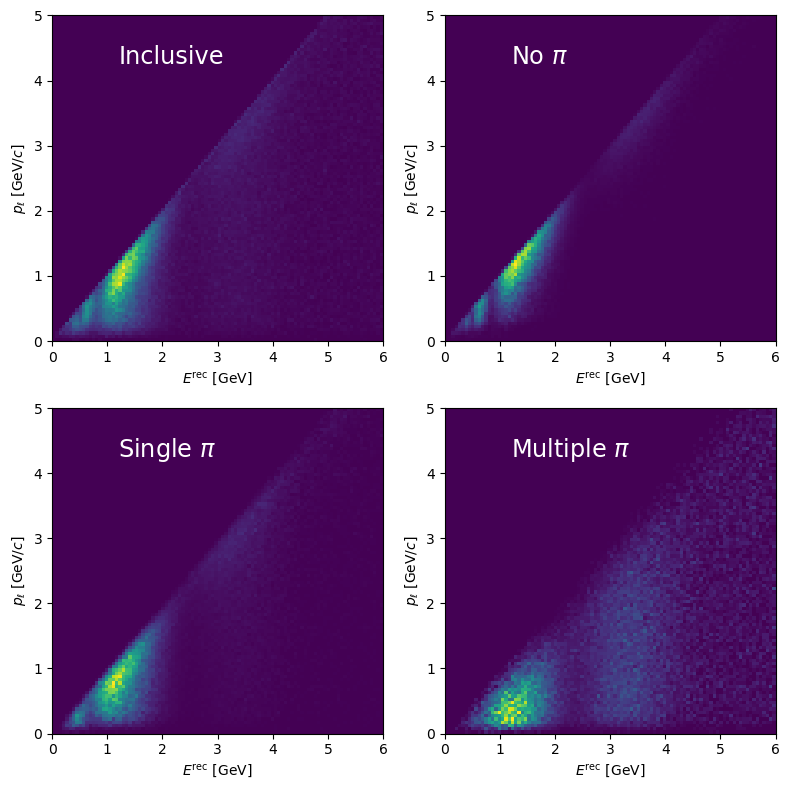

In [9]:
import matplotlib.pyplot as plt

def plot(xbins, ybins, doosc=False):
    fig, axes = plt.subplots(2,2, figsize=(8,8))
    
    hist = pn.HistFrame(pn.Binning.lin_spaceND([xbins[1],ybins[1]],[xbins[2],ybins[2]]), "CC+NC Inc")

    fillops = [pn.HistFrame.fill_column(0), pn.HistFrame.categorize_by("topo", topo_labels)]

    if doosc:
        fillops.append(pn.HistFrame.weight_by("wosc"))
    
    hist.fill(ef, [xbins[0],ybins[0]], fillops)
    hist = hist.finalise()
    hist = hist.scale(gnorm.fatx_per_sumweights())
    
    hist.mpl().colormesh(column="CC+NC Inc",plot_axis=axes[0][0])
    axes[0][0].text(xbins[1][1]*0.2,ybins[1][1] * 0.85,"Inclusive",color="white", size="xx-large")
    
    hist.mpl().colormesh(column="CC0Pi",plot_axis=axes[0][1])
    axes[0][1].text(xbins[1][1]*0.2,ybins[1][1] * 0.85,r"No $\pi$",color="white", size="xx-large")
    
    hist.mpl().colormesh(column="CC1Pi",plot_axis=axes[1][0])
    axes[1][0].text(xbins[1][1]*0.2,ybins[1][1] * 0.85,r"Single $\pi$",color="white", size="xx-large")
    
    hist.mpl().colormesh(column="CCMultiPi",plot_axis=axes[1][1])
    axes[1][1].text(xbins[1][1]*0.2,ybins[1][1] * 0.85,r"Multiple $\pi$",color="white", size="xx-large")
        
    fig.tight_layout()
    fig.show()

# plot(["enu", [0,5,100], r"$E_\nu$ [GeV]"], ["plep", [0,5,100], r"$p_\ell$ [GeV/$c$]"], False)
# plot(["ERecBias", [-0.2,0.2,40], r"ERecBias"], ["enu", [0,5,100], r"$E_\nu$ [GeV]"], False)
plot(["plep", [0,5,100], r"$p_\ell$ [GeV/$c$]"], ["EHadAv_Mnv", [0,5,100], r"$E_\mathrm{had}^\mathrm{rec}$ [GeV]"], True)
plot(["ERec", [0,6,100], r"$E^\mathrm{rec}$ [GeV]"], ["plep", [0,5,100], r"$p_\ell$ [GeV/$c$]"], True)

# plot(["enu", [0,5,100], r"$E_\nu$ [GeV]"],["ERec", [0,5,100], r"$E^\mathrm{rec}$ [GeV]"], True)

# Analysis Binning

Define the analysis binning, try in ERec and plep, only want to bin in the lower half triangle (enurec = plep + ehadav)

In [10]:
class observation:
    def __init__(self):
        self.proj = []
        self.bins = []
    def add_observables(self, projections, bins):
        if isinstance(projections, list):
            self.proj.extend(projections)
        else:
            self.proj.append(projections)
        self.bins.append(bins)
    def plot(self, ef, osc=False):
        
        projs = self.proj
        
        if len(projs) == 1:
            fig, axes = plt.subplots(1,1, figsize=(4,4))
        elif len(projs) == 2:
            fig, axes = plt.subplots(2,2, figsize=(8,8))
        else:
            raise RuntimeError("Cannot currently have a N>2 dimension analysis")

        anabins = self.anabins()

        hist = pn.HistFrame(anabins, "CC+NC Inc")
        
        fillops = [pn.HistFrame.fill_column(0), 
                   pn.HistFrame.categorize_by("topo", topo_labels)]
        if osc:
            fillops.append(pn.HistFrame.weight_by("wosc"))
        
        hist.fill(ef, projs, fillops)
        hist = hist.finalise()
        hist = hist.scale(gnorm.fatx_per_sumweights())
        if len(projs) == 1:
            hist.mpl().hist_all(histtype="step", plot_axis=axes)
            axes.legend()
            
        elif len(projs) == 2:
            hist.mpl().colormesh(column="CC+NC Inc",plot_axis=axes[0][0])
            axes[0][0].text(1,4,"Inclusive",color="black", size="xx-large")
            
            hist.mpl().colormesh(column="CC0Pi",plot_axis=axes[0][1])
            axes[0][1].text(1,4,r"No $\pi$",color="black", size="xx-large")
            
            hist.mpl().colormesh(column="CC1Pi",plot_axis=axes[1][0])
            axes[1][0].text(1,4,r"Single $\pi$",color="black", size="xx-large")
            
            hist.mpl().colormesh(column="CCMultiPi",plot_axis=axes[1][1])
            axes[1][1].text(1,4,r"Multiple $\pi$",color="black", size="xx-large")
            
        fig.tight_layout()
        fig.show()

    def projs(self):
        return self.proj
    def anabins(self):
        return pn.Binning.product(self.bins)


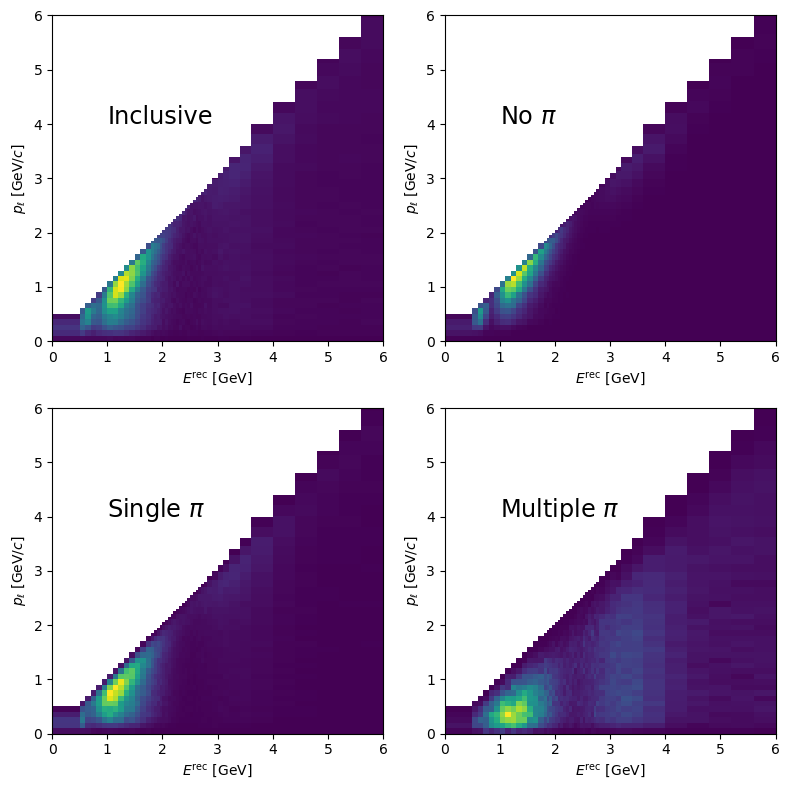

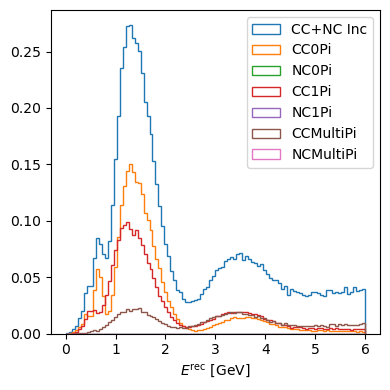

In [11]:
binExts = []
ENuBinEdges_fine = [0,0.5,0.6,0.7,0.8,0.9,1,
                     1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.85,1.9,1.95,2,
                     2.05,2.1,2.15,2.2,2.25,2.3,2.35,2.4,2.45,2.5,2.55,2.6,2.65,2.7,2.75,2.8,2.9,3,
                     3.1,3.2,3.4,3.6,4,
                     4.4,4.8,5.2,5.6,6]

PLepBWMin = 0.1 #100 MeV
PLepBWMaxFraction = 0.05 # 5% of PLep

for bi in range(len(ENuBinEdges_fine)-1):
    ERecExt = pn.Binning.SingleExtent(ENuBinEdges_fine[bi], ENuBinEdges_fine[bi+1])
    PLepBL = 0
    while PLepBL <= ENuBinEdges_fine[bi+1]:
        PLepBW = max(PLepBWMin, PLepBWMaxFraction * (2.0*PLepBL + PLepBWMin)/2.0)
        PLepBU = min(PLepBL + PLepBW,ENuBinEdges_fine[bi+1])

        if PLepBU <= PLepBL:
            break

        PLepExt = pn.Binning.SingleExtent(PLepBL, PLepBU)
        binExts.append([ERecExt, PLepExt])
        PLepBL = PLepBU

testana = observation()
testana.add_observables(["ERec","plep"], 
                        pn.Binning.from_extents(binExts, [r"$E^\mathrm{rec}$ [GeV]", r"$p_\ell$ [GeV/$c$]"]))

testana.plot(ef, True)

testana2 = observation()
testana2.add_observables("ERec", 
                        pn.Binning.lin_space(0,6,100, r"$E^\mathrm{rec}$ [GeV]"))

testana2.plot(ef, True)

anabins = testana.anabins()
nanabins = len(anabins.bins)

# Systematic Model

Specify 2D or 3D true kinematic space used to define 'binned' normalisation model

In [12]:
class model:
    def __init__(self):
        self.dims = []
    def add_axis(self, projection, binning):
        self.dims.append((projection, binning))
    def plot(self,ef):
        fig, axes = plt.subplots(1,len(self.dims), figsize=(4*len(self.dims),4))

        for ax, d in zip(axes, self.dims):
            hist = pn.HistFrame(d[1])
            hist.fill(ef, d[0], [pn.HistFrame.fill_column(0), pn.HistFrame.categorize_by("topo", topo_labels)])
            hist = hist.finalise()
            hist = hist.scale(gnorm.fatx_per_sumweights())
            hist.mpl().hist_all(histtype="step", plot_axis=ax)

        axes[0].legend()
        fig.show()

    def systbins(self):
        return pn.Binning.product([d[1] for d in self.dims])
    def projs(self):
        return [d[0] for d in self.dims]


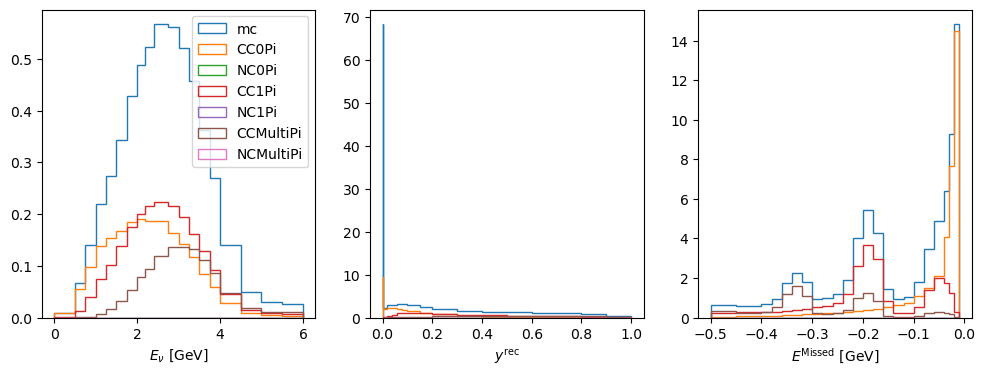

In [13]:
test3Dmodel = model()
test3Dmodel.add_axis("enu", 
                     pn.Binning.contiguous(
                         [0,0.5,0.75,1,1.25,1.5,1.75,2,2.2,2.4,2.75,3,3.25,3.5,3.75,4,4.5,5,5.5,6], 
                         r"$E_\nu$ [GeV]"))
test3Dmodel.add_axis("YRec", 
                     pn.Binning.contiguous([0,0.0005,0.02,0.04,0.06,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                                           r"$y^\mathrm{rec}$"))
test3Dmodel.add_axis("ERecMissed", 
                     pn.Binning.contiguous(
                         list(reversed([-0.01,-0.02,-0.03,-0.04,-0.06,-0.08,-0.1,-0.12,-0.14,-0.16,-0.18,
                                        -0.2,-0.22,-0.24,-0.26,-0.28,-0.3,-0.32,-0.34,-0.36,-0.38,-0.4,-0.45,-0.5]))
                         ,r"$E^\mathrm{Missed}$ [GeV]"))

test3Dmodel.plot(ef)

In [14]:
systbins = test3Dmodel.systbins()
nsyst = len(systbins.bins)
print(f"Have {nsyst} normalisation bins in the model")

Have 6992 normalisation bins in the model


In [15]:
df['systbin'] = df.apply(lambda x: systbins.find_bin([x["enu"], x["YRec"], x["ERecMissed"]]), axis=1)
df

,event.number,weight.cv,fatx_per_sumw.pb_per_target.estimate,fatx_per_sumw.pb_per_nucleon.estimate,process.id,enu,topo,q0,q3,W,plep,EHadAv_Mnv,wosc,ERec,YRec,ERecMissed,ERecBias,systbin
5,7,1.0,6.948408e-02,5.790340e-03,600,4.428937,2,3.231451,3.677136,2.176015,1.192815,2.523430,0.350898,3.716245,0.679027,-0.712692,-0.160917,4294967295
7,9,1.0,5.558726e-02,4.632272e-03,500,2.795027,2,1.441489,1.963942,1.304047,1.349408,1.393553,0.016212,2.742961,0.508047,-0.052067,-0.018628,5995
8,12,1.0,4.275943e-02,3.563286e-03,300,2.598061,0,0.546930,0.905409,2.273883,2.048408,0.438915,0.012332,2.487323,0.176461,-0.110738,-0.042623,5006
9,13,1.0,3.970519e-02,3.308766e-03,400,3.146805,0,0.706227,0.898746,1.374674,2.438290,0.653080,0.067379,3.091369,0.211259,-0.055436,-0.017617,5939
10,14,1.0,3.705817e-02,3.088181e-03,600,5.904933,4,4.393155,4.694525,2.435399,1.508082,3.799000,0.581567,5.307082,0.715836,-0.597851,-0.101246,4294967295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745225,999973,1.0,5.558871e-07,4.632392e-08,400,1.062748,2,0.561350,0.942154,1.216885,0.490139,0.233056,0.491653,0.723195,0.322259,-0.339553,-0.319504,1694
745230,999978,1.0,5.558843e-07,4.632369e-08,500,3.218134,-1,1.550063,1.794878,1.559174,1.664722,1.491231,0.081680,3.155952,0.472514,-0.062182,-0.019322,5673
745233,999984,1.0,5.558810e-07,4.632341e-08,200,3.414840,2,0.950818,1.600283,0.938272,2.461756,0.671868,0.124518,3.133624,0.214406,-0.281217,-0.082351,2292
745235,999986,1.0,5.558798e-07,4.632332e-08,600,2.822932,2,2.292094,2.786991,1.638997,0.520217,1.761934,0.018588,2.282151,0.772050,-0.540781,-0.191567,4294967295


We can now look at the number of events controlled by each systematic. Ideally this would be fairly flat...

In [16]:
ef = pa.Table.from_pandas(df)

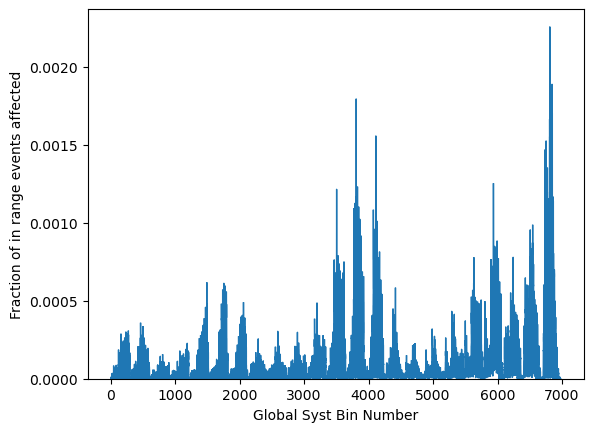

In [17]:
systbincount = pn.HistFrame(pn.Binning.lin_space(0,len(systbins.bins),len(systbins.bins),"Global Syst Bin Number"))

systbincount.fill(ef, "systbin")
systbincount = systbincount.scale(1.0/float(ef.num_rows))
systbincount.mpl().hist(histtype="step")
plt.ylabel("Fraction of in range events affected")
plt.show()

In [18]:
import numpy as np

thresholds = [0.00001,0.0001,0.0005, 0.001, 0.0015, 0.002]

bc = systbincount.sumweights[:, 0]

for t in thresholds:
    nbins_above_t = np.count_nonzero(bc > t)
    print(f"{nbins_above_t}/{len(bc)} syst params affect more than {t*100}% of the events")

5394/6992 syst params affect more than 0.001% of the events
2171/6992 syst params affect more than 0.01% of the events
285/6992 syst params affect more than 0.05% of the events
42/6992 syst params affect more than 0.1% of the events
11/6992 syst params affect more than 0.15% of the events
1/6992 syst params affect more than 0.2% of the events


In [19]:
# Most populated bins

print("              enu            YRec       ERecMissed")
for bi in np.nditer(np.nonzero(bc > 0.002)):
    bindefs = " ".join(str(b) for b in systbins.bins[bi])
    print(f"Bin {bi}: {bindefs}")

              enu            YRec       ERecMissed
Bin 6811: (2.40 - 2.75) (0.10 - 0.15) (-0.02 - -0.01)


# Putting it all together

In [20]:
import pyNUISANCE as pn
import numpy as np
import pyarrow as pa
import pandas as pd

from pyProSelecta import event, part, unit, pdg, energy, kinetic_energy
from pyNuHepMC import EventUtils
from pyHepMC3.pyHepMC3.HepMC3 import FourVector

import matplotlib.pyplot as plt

def EHadAv_Mnv(ev):
    erec = 0
    for fsp in event.all_out_part(ev):
        pid = fsp.pid()

        if abs(pid) == 13:
            continue
        elif pid == 2112:
            continue
        elif pid == 2212 or abs(pid) == 211:
            erec += kinetic_energy(fsp)
        elif pid == 111 or abs(pid) == 11 or pid == 22:
            erec += energy(fsp)
    return erec / unit.GeV

evs = pn.EventSource("../q0q3plots/NuWro.numu.numu_flux.flux_dune_neutrino_ND.1203.evts.root")

wnf5_disp = pn.Prob3plusplusWeightCalc()
wnf5_disp.set_parameters({"baseline_km": 1300, "NuFit:5.2": 1, "osc:numu_disp":1})

efa = pn.EventFrameGen(evs)\
    .filter(pn.pps.ext.isCC) \
    .add_column("enu",pn.pps.ext.enu_GeV) \
    .add_int_column("topo",pn.pps.ext.final_state_topology) \
    .add_column("plep",pn.pps.ext.plep_GeV) \
    .add_column("EHadAv_Mnv",EHadAv_Mnv)\
    .firstArrow(int(1E6))

pd.options.mode.copy_on_write = True

df = efa.to_pandas()

df["ERec"] = df["plep"] + df["EHadAv_Mnv"]

df = df[df["ERec"] < 6]

df["YRec"] = df["EHadAv_Mnv"]/df["ERec"]
df["ERecMissed"] = (df["ERec"] - df["enu"])

efa = pa.Table.from_pandas(df)

Only Concrete Python instances allowed as dict inputs to YAML conversion!


In [21]:
from math import inf

def nllh(data, mc):
    if np.count_nonzero(mc < 0):
        return inf
    mcad = np.logical_and(mc > 0,data > 0)
    mco = np.logical_and(mc > 0,data == 0)

    mc_mcad = mc[mcad]
    data_mcad = data[mcad]

    nllh = np.sum(mc_mcad - data_mcad + data_mcad * np.log(np.divide(data_mcad ,mc_mcad)))
    nllh = nllh + np.sum(mc[mco])

    return nllh

class model:
    def __init__(self):
        self.dims = []
    def add_axis(self, projection, binning):
        self.dims.append((projection, binning))
    def plot(self,ef):
        fig, axes = plt.subplots(1,len(self.dims), figsize=(4*len(self.dims),4))

        for ax, d in zip(axes, self.dims):
            hist = pn.HistFrame(d[1])
            hist.fill(ef, d[0], [pn.HistFrame.fill_column(0), pn.HistFrame.categorize_by("topo", topo_labels)])
            hist = hist.finalise()
            hist.mpl().hist_all(histtype="step", plot_axis=ax)

        axes[0].legend()
        fig.show()

    def systbins(self):
        return pn.Binning.product([d[1] for d in self.dims])
    def projs(self):
        return [d[0] for d in self.dims]

class observation:
    def __init__(self):
        self.proj = []
        self.bins = []
    def add_observables(self, projections, bins):
        if isinstance(projections, list):
            self.proj.extend(projections)
        else:
            self.proj.append(projections)
        self.bins.append(bins)
        
    def plot(self, ef, osc=False):
        
        projs = self.proj
        
        if len(projs) == 1:
            fig, axes = plt.subplots(1,1, figsize=(4,4))
        elif len(projs) == 2:
            fig, axes = plt.subplots(2,2, figsize=(8,8))
        else:
            raise RuntimeError("Cannot currently have a N>2 dimension analysis")

        anabins = self.anabins()

        hist = pn.HistFrame(anabins, "CC+NC Inc")
        
        fillops = [pn.HistFrame.fill_column(0), 
                   pn.HistFrame.categorize_by("topo", topo_labels)]
        if osc:
            fillops.append(pn.HistFrame.weight_by("wosc"))
        
        hist.fill(ef, projs, fillops)
        hist = hist.finalise()
        if len(projs) == 1:
            hist.mpl().hist_all(histtype="step", plot_axis=axes)
            axes.legend()
            
        elif len(projs) == 2:
            hist.mpl().colormesh(column="CC+NC Inc",plot_axis=axes[0][0])
            axes[0][0].text(1,4,"Inclusive",color="black", size="xx-large")
            
            hist.mpl().colormesh(column="CC0Pi",plot_axis=axes[0][1])
            axes[0][1].text(1,4,r"No $\pi$",color="black", size="xx-large")
            
            hist.mpl().colormesh(column="CC1Pi",plot_axis=axes[1][0])
            axes[1][0].text(1,4,r"Single $\pi$",color="black", size="xx-large")
            
            hist.mpl().colormesh(column="CCMultiPi",plot_axis=axes[1][1])
            axes[1][1].text(1,4,r"Multiple $\pi$",color="black", size="xx-large")
            
        fig.tight_layout()
        fig.show()

    def projs(self):
        return self.proj
    def anabins(self):
        return pn.Binning.product(self.bins)

class online_stats:
    def __init__(self, nanabins):
        self.agg = (0, np.zeros(nanabins), np.zeros(nanabins))
## From https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm

    # For a new value new_value, compute the new count, new mean, the new M2.
    # mean accumulates the mean of the entire dataset
    # M2 aggregates the squared distance from the mean
    # count aggregates the number of samples seen so far
    def update(self, new_value):
        (count, mean, M2) = self.agg
        count += 1
        delta = new_value - mean
        mean += delta / count
        delta2 = new_value - mean
        M2 += delta * delta2
        self.agg = (count, mean, M2)
    
    # Retrieve the mean, variance and sample variance from an aggregate
    def finalize(self):
        (count, mean, M2) = self.agg
        if count < 2:
            return float("nan")
        else:
            (mean, variance, sample_variance) = (mean, M2 / count, M2 / (count - 1))
            return (mean, variance, sample_variance)

class Analysis:
    def __init__(self, efa, observables, systematic_model, evrate=10000):
        self.ef = efa

        self.obs = observables

        self.anabins = self.obs.anabins()
        self.nanabins = len(self.anabins.bins)
        self.anabinIds = pn.Binning.find_bins(self.anabins, self.ef, self.obs.projs())
        
        self.systs = systematic_model

        self.systbins = self.systs.systbins()
        self.nsyst = len(self.systbins.bins)
        
        self.systbinIds = pn.Binning.find_bins(self.systbins, self.ef, self.systs.projs())
        self.systbin_affected = np.logical_and(self.systbinIds >= 0,self.systbinIds < self.nsyst)
        self.nevents = len(self.systbinIds)

        self.scalef = 1
        self.scalef = float(evrate)/np.sum(self.predict().sumweights[:,0])
        
        self.datah = self.predict()
        self.data = self.datah.sumweights[:,0]

    def plot_systbins_event_rate(self):
        systbincount = pn.HistFrame(pn.Binning.lin_space(0,len(self.systbins.bins),len(self.systbins.bins),"Global Syst Bin Number"))

        systbincount.fill(self.ef, [], [pn.HistFrame.fill_column(0), pn.HistFrame.prebinned_array(self.systbinIds)])
        systbincount.mpl().hist(histtype="step")
        plt.ylabel("Number events affected")
        plt.show()

    def calc_event_weights(self, paramvs):
        ws = np.ones(self.nevents)
        ws[self.systbin_affected] = paramvs[self.systbinIds[self.systbin_affected]]
        return ws
    
    def predict(self, paramvs=None):
        Ana2dHist = pn.HistFrame(self.anabins)
    
        fillops = [pn.HistFrame.fill_column(0), pn.HistFrame.prebinned_array(self.anabinIds)]
    
        if paramvs is not None:
            fillops.append(pn.HistFrame.weight_by_array(self.calc_event_weights(paramvs)))
        
        Ana2dHist.fill(self.ef, [], fillops)
        
        return Ana2dHist.scale(self.scalef)

    def predict_other(self, anabins, projs=[], binIds=None, paramvs=None):
        Ana2dHist = pn.HistFrame(anabins)
    
        fillops = [pn.HistFrame.fill_column(0)]

        if binIds is not None:
            fillops.append(pn.HistFrame.prebinned_array(binIds))
    
        if paramvs is not None:
            fillops.append(pn.HistFrame.weight_by_array(self.calc_event_weights(paramvs)))
        
        Ana2dHist.fill(self.ef, projs, fillops)
    
        return Ana2dHist.scale(self.scalef)

    def nllh(self,paramvs):
        return nllh(self.data, self.predict(paramvs).sumweights[:, 0])
    
    def throws(self, toy_params, anabins=None, projs=None):

        if anabins is None:
            anabins = self.anabins
            projs = self.obs.projs()

        os = online_stats(len(anabins.bins))

        anabinIds = pn.Binning.find_bins(anabins, self.ef, projs)
        
        for ti in range(toy_params.shape[0]):
            os.update(self.predict_other(anabins, binIds=anabinIds, paramvs=toy_params[ti,:]).sumweights[:,0])
        fin = os.finalize()

        cv = self.predict_other(anabins=anabins, binIds=anabinIds)
        cv.sumweights = fin[0]
        
        np.seterr(divide='ignore', invalid='ignore')
        stddv = self.predict_other(anabins=anabins, binIds=anabinIds)
        cv.variances = fin[2]

        return cv


19 Systematic Parameters


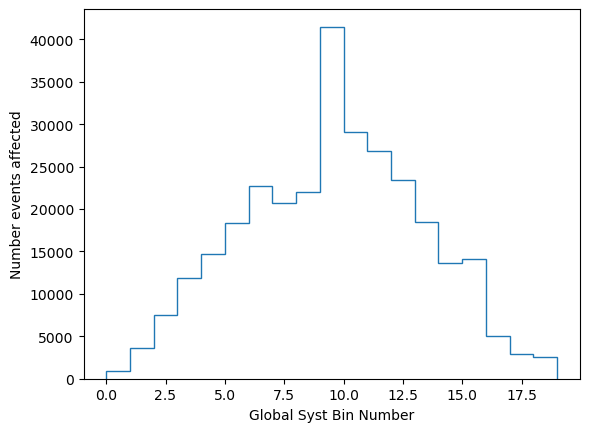

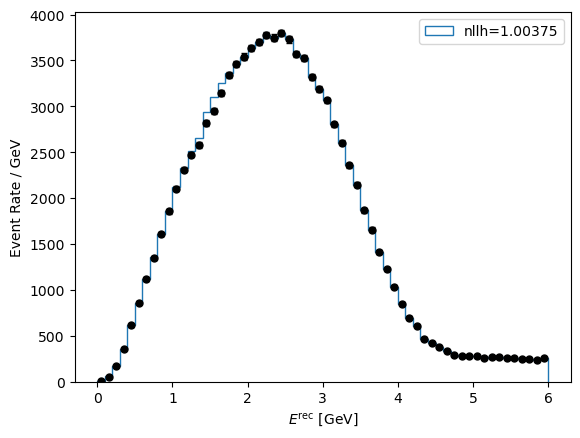

In [22]:
obs = observation()
obs.add_observables("ERec", pn.Binning.lin_space(0,6,60,r"$E^\mathrm{rec}$ [GeV]"))

systmodel = model()
# systmodel.add_axis("ERecMissed", 
#                      pn.Binning.contiguous(
#                          list(reversed([-0.01,-0.05,-0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5, -0.55, -0.6]))
#                          ,r"$E^\mathrm{Missed}$ [GeV]"))
systmodel.add_axis("enu", 
                     pn.Binning.contiguous(
                         [0,0.5,0.75,1,1.25,1.5,1.75,2,2.2,2.4,2.75,3,3.25,3.5,3.75,4,4.5,5,5.5,6], 
                         r"$E_\nu$ [GeV]"))
# systmodel.add_axis("ERec", 
#                      pn.Binning.contiguous(
#                          [2.2,2.3], 
#                          r"$E_\nu$ [GeV]"))
print(f"{len(systmodel.systbins().bins)} Systematic Parameters")

myana = Analysis(efa,obs,systmodel, 10000)
myana.plot_systbins_event_rate()
plt.show()
myana.datah.finalise().mpl().data_hist()
paramvs = np.ones(myana.nsyst)
paramvs[5] = 1.1
myana.predict(paramvs=paramvs).finalise().mpl().hist(histtype="step", label=f"nllh={myana.nllh(paramvs):g}")
plt.ylabel("Event Rate / GeV")
plt.legend()
plt.show()

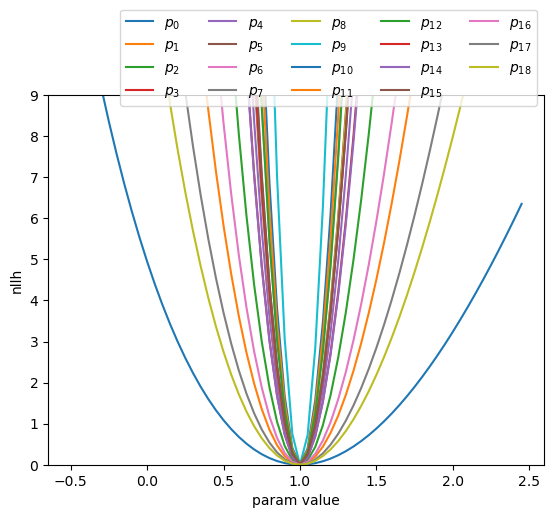

In [23]:
#lhood scans
for p_i in range(myana.nsyst):
    x = []
    y = []
    for i in np.arange(-3,3,0.1):
        paramvs = np.ones(myana.nsyst)
        paramvs[p_i] = 1 + i*0.5
        x.append(paramvs[p_i])
        y.append(myana.nllh(paramvs))

    plt.plot(x,y, label=f"$p_{{{p_i}}}$")
plt.legend(ncol=5,bbox_to_anchor=(0., 1.05, 1., 0.2))
plt.xlabel("param value")
plt.ylabel("nllh")
plt.ylim(0,9)
plt.show()

In [24]:
# from https://exowanderer.medium.com/metropolis-hastings-mcmc-from-scratch-in-python-c21e53c485b7
from math import exp

class chain:
    def __init__(self, nparams):
        self.nsteps = 0
        self.capacity = 1000
        self.nparams = nparams

        self.state = np.zeros((self.nparams+2, self.capacity))
    
    def _expand(self):
        self.capacity = self.capacity + 1000
        hold = np.copy(self.state)
        self.state = np.zeros((self.nparams+2, self.capacity))
        self.state[:,0:self.nsteps] = hold
    
    def step(self, pvals, lhood, step_prob):
        if self.nsteps == self.capacity:
            self._expand()
            
        self.state[0, self.nsteps] = lhood
        self.state[1, self.nsteps] = step_prob
        self.state[2:,self.nsteps] = pvals
        self.nsteps += 1

    def _acf(self, p, stop=10000, step=25):
        stop = min(stop, self.nsteps)
        return np.array([np.corrcoef(self.state[p,:-i],self.state[p,i:])[0,1] for i in range(1, stop, step)])
    
    def trace_lhood(self, burnin=0):
        return self.state[0,burnin:]

    def acf_lhood(self, stop=10000, step=25):
        return self._acf(0, stop=stop, step=step)

    def trace_param(self, p_i, NSteps=10000, burnin=0):
        nstepstotrace = min(NSteps, self.nsteps - burnin)
        return self.state[2 + p_i, burnin:burnin+nstepstotrace]

    def acf_param(self, p_i, stop=10000, step=25):
        return self._acf(2 + p_i, stop, step)

    def _plot_trace(self, trace, plot_axis=None, NSteps=10000, nskip=10, burnin=0, label=""):
        if plot_axis is None:
            plot_axis = plt.gca()
        nstepstoplot = min(NSteps, trace.shape[0] - burnin)
        plot_axis.plot(np.arange(burnin, nstepstoplot + burnin, nskip), trace[np.arange(0, nstepstoplot, nskip)], label=label)

    def plot_param_trace(self, p_i, plot_axis=None, NSteps=10000, nskip=10, burnin=0):
        self._plot_trace(self.trace_param(p_i, NSteps=10000, burnin=burnin), plot_axis, NSteps=NSteps, nskip=nskip, burnin=burnin, label=f"param {p_i}")
    
    def plot_tprob_trace(self, plot_axis=None, NSteps=10000, navg=100, burnin=0):
        if plot_axis is None:
            plot_axis = plt.gca()

        nstepstoplot = min(NSteps, self.nsteps - burnin) - navg
        
        x = [x + navg/2.0 for x in range(burnin, burnin+nstepstoplot, navg)]
        y = [np.average(samples.state[1,x:x+navg]) for x in range(burnin, burnin+nstepstoplot, navg)]
        
        plot_axis.set_ylabel("Avg. Acceptance prob")
        plot_axis.set_xlabel("Step")
        plot_axis.plot(x,y)

    def plot_llh_trace(self, plot_axis=None, NSteps=10000, nskip=10, burnin=0):
        self._plot_trace(self.trace_lhood(burnin=burnin), plot_axis, NSteps=NSteps, nskip=nskip, burnin=burnin)

    def _plot_acf(self, trace, plot_axis=None, label="", stop=10000, step=25):
        if plot_axis is None:
            plot_axis = plt.gca()
        plot_axis.plot(np.arange(1, stop, step), trace, label=label)
        
    def plot_param_acf(self, p_i, plot_axis=None, stop=10000, step=25):
        self._plot_acf(self.acf_param(p_i,stop,step), plot_axis, label=f"param {p_i}", stop=stop, step=step)

    def plot_llh_acf(self, plot_axis=None, stop=10000, step=25):
        self._plot_acf(self.acf_lhood(stop,step), plot_axis, stop=stop, step=step)

    def plot_param_post(self, p_i, \
                        bins=[-3,3,100], \
                        plot_axis=None, NSteps=10000, burnin=0):
        h = pn.HistFrame(pn.Binning.lin_space(bins[0],bins[1],bins[2],fr"$p_{{{p_i}}}$ value"), "steps at value")
        for v in self.trace_param(p_i, NSteps=NSteps, burnin=burnin):
            h.fill(v, 1.0)
        return h.mpl().hist(histtype="step", plot_axis=plot_axis)

    def plot_param2D_post(self, p_i, p_j, \
                          bins=[[-3,3,100],[-3,3,100]], \
                          plot_axis=None, NSteps=10000, burnin=0):
        h = pn.HistFrame(pn.Binning.lin_spaceND(bins,[fr"$p_{{{p_i}}}$ value", fr"$p_{{{p_j}}}$ value"]), "steps at value")
        for vi, vj in zip(self.trace_param(p_i, NSteps=NSteps, burnin=burnin),self.trace_param(p_j, NSteps=NSteps, burnin=burnin)):
            h.fill([vi,vj], 1.0)
        return h.mpl().colormesh(plot_axis=plot_axis)

    def covmat(self, NSteps=10000, burnin=0):
        nstepstoplot = min(NSteps, self.nsteps - burnin)
        return np.cov(self.state[2:,burnin:burnin+nstepstoplot])

    def plot_covmat(self, NSteps=10000, burnin=0):
        cvmx = pn.HistFrame(pn.Binning.lin_spaceND([[0,self.nparams,self.nparams],[0,self.nparams,self.nparams]]))
        covmat = self.covmat(NSteps=NSteps, burnin=burnin)
        for i in range(self.nparams):
            for j in range(self.nparams):
                cvmx.fill([i,j],covmat[i,j])
        return cvmx.mpl().colormesh()

In [49]:
from math import isfinite

from time import time

class proposal:
    def __init__(self, stepsize, nparams):
        self.nparams = nparams
        self.rnjesus = np.random.default_rng()
        self.covmats = [np.identity(nparams) * stepsize * stepsize,]

    def propose(self):
        return self.rnjesus.multivariate_normal(np.zeros(self.nparams), self.covmats[-1])

    def update(self, covmat):
        # from https://www.probability.ca/jeff/ftpdir/adaptex.pdf
        self.covmats.append(covmat * (2.38 * 2.38 / self.nparams))

    def print_diagnostics(self):
        print("Effective steps:")
        eigenvalues, eigenvectors = np.linalg.eig(self.covmats[-1])
        for i in range(eigenvalues.shape[0]):
            print(f"\t{i}: ", eigenvectors[i, :] * np.sqrt(eigenvalues[i]))

        print("")

    def step_sizes(self):
        return np.array([np.sort(np.sqrt(np.linalg.eig(cv)[0])) for cv in self.covmats])

    def plot_step_sizes(self):
        ss = proposer.step_sizes()
        for i in range(self.nparams):
            plt.plot(ss[:,i], label=fr"$p_{{{i}}}$")
        plt.ylabel("Effecive PCA step size")
        plt.xlabel("update")
        plt.legend()
        plt.show()
    
    def plot_covmat(self):
        cvmx = pn.HistFrame(pn.Binning.lin_spaceND([[0,self.nparams,self.nparams],[0,self.nparams,self.nparams]]))
        for i in range(self.nparams):
            for j in range(self.nparams):
                cvmx.fill([i,j],self.covmats[-1][i,j])
        return cvmx.mpl().colormesh()

def mcmc_updater(curr_state, curr_nllh, fnllh, proposer):
    # Generate a proposal state using the proposal distribution
    # Proposal state == new guess state to be compared to current
    proposal_state = curr_state + proposer.propose()

    # Calculate the acceptance criterion
    prop_nllh = fnllh(proposal_state)

    if not isfinite(prop_nllh):
        return curr_state, curr_nllh, 0
    
    sp = min(1, exp(curr_nllh - prop_nllh))

    # Generate a random number between 0 and 1
    u = np.random.uniform(0, 1)

    # If the acceptance criterion is greater than the random number,
    # accept the proposal state as the current state
    if u <= sp:
        return proposal_state, prop_nllh, sp

    return curr_state, curr_nllh, sp

def metropolis_hastings(
        fnllh, initial_state, num_samples, stepsize, update_ntimes=5, update_every=10000, proposer=None):

    samples = chain(len(initial_state))
    if proposer is None:
        proposer = proposal(stepsize, len(initial_state))

    # Set the current state to the initial state
    curr_state = initial_state
    curr_nllh = fnllh(curr_state)

    start = time()
    avg_step_prob = 0

    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine
        curr_state, curr_nllh, step_prob = mcmc_updater(
            curr_state=curr_state,
            curr_nllh=curr_nllh,
            fnllh=fnllh,
            proposer=proposer
        )

        avg_step_prob = avg_step_prob + step_prob

        samples.step(curr_state, curr_nllh, step_prob)

        if (i > 0) and (i%update_every == 0):
            end = time()
            print(f"processed {update_every} steps in {end - start:.2g}s ({1000.0 *float(end - start)/float(update_every):.2g} ms/st) with avg. acceptance prob: {avg_step_prob/float(update_every):.2g}")
            if (update_ntimes > 0):
                proposer.update(samples.covmat(NSteps=i))
                print("\tUpdated proposer covariance")
                update_ntimes = update_ntimes - 1
            start = time()
            avg_step_prob = 0

    return samples, proposer

# Gaussian Target Dummy

In [65]:
from math import pi

class mvpdf:
    def __init__(self, loc, cvmx):
        cvmx_det = np.linalg.det(cvmx)
        if (cvmx_det <= 0):
            raise RuntimeError(f"Invalid covariance matrix with det = {cvmx_det}:\n{cvmx}")
        self.loc = loc
        self.k = len(loc)
        self.icv = np.linalg.inv(cvmx)
        self.pref = np.power(2.0*pi,-0.5*self.k) / np.sqrt(cvmx_det)
        
    def val(self, loc):
        pdf = self.pref * exp(-0.5 * (loc - self.loc).T @ self.icv @ (loc - self.loc))
        return pdf

    def nllh(self, loc):
        return -np.log(self.val(loc))

    def __call__(self, loc):
        return self.nllh(loc)

In [68]:
%%time

cvmx = np.array([[1,   -0.5,   0.25, 0.1,  0.25], 
                 [-0.5, 1,     0.3,  0.7, 0.25], 
                 [0.25, 0.3,   1,    0.13, 0.4 ],
                 [0.1,  0.7,  0.13, 1,     0.1],
                 [0.25,    0.25, 0.4,  0.1,   1 ]])
samples, proposer = metropolis_hastings(fnllh=mvpdf(np.zeros(cvmx.shape[0]), cvmx), 
                             initial_state=np.random.normal(np.zeros(cvmx.shape[0]),0.5),
                             num_samples=2000000,
                             stepsize=0.1,
                             update_ntimes=2, update_every=50000)

processed 50000 steps in 1.6s (0.032 ms/st) with avg. acceptance prob: 0.51
	Updated proposer covariance
processed 50000 steps in 1.8s (0.035 ms/st) with avg. acceptance prob: 0.3
	Updated proposer covariance
processed 50000 steps in 1.8s (0.035 ms/st) with avg. acceptance prob: 0.29
processed 50000 steps in 1.8s (0.036 ms/st) with avg. acceptance prob: 0.29
processed 50000 steps in 1.9s (0.039 ms/st) with avg. acceptance prob: 0.29
processed 50000 steps in 1.9s (0.038 ms/st) with avg. acceptance prob: 0.29
processed 50000 steps in 1.8s (0.037 ms/st) with avg. acceptance prob: 0.29
processed 50000 steps in 1.8s (0.036 ms/st) with avg. acceptance prob: 0.29
processed 50000 steps in 1.9s (0.038 ms/st) with avg. acceptance prob: 0.29
processed 50000 steps in 1.9s (0.038 ms/st) with avg. acceptance prob: 0.3
processed 50000 steps in 1.9s (0.038 ms/st) with avg. acceptance prob: 0.29
processed 50000 steps in 1.9s (0.038 ms/st) with avg. acceptance prob: 0.29
processed 50000 steps in 1.9s (0

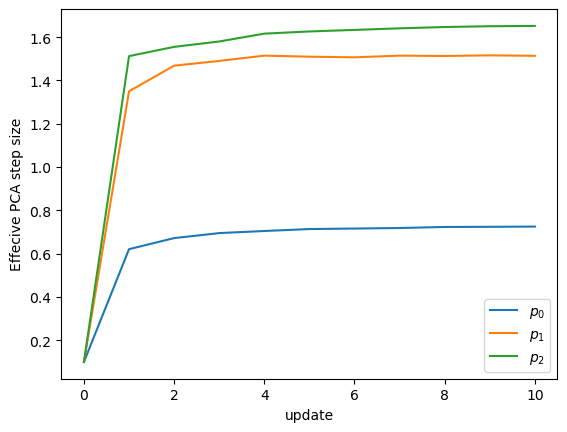

In [28]:
proposer.plot_step_sizes()

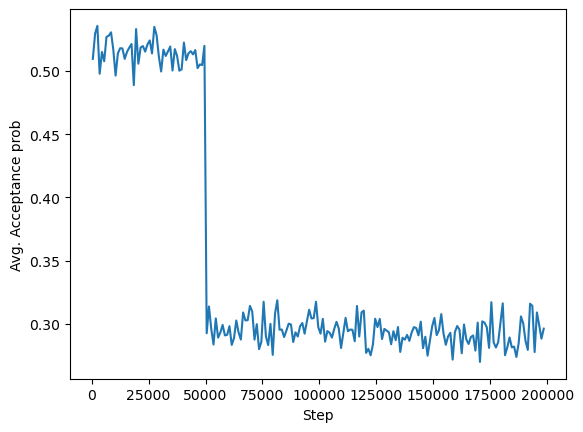

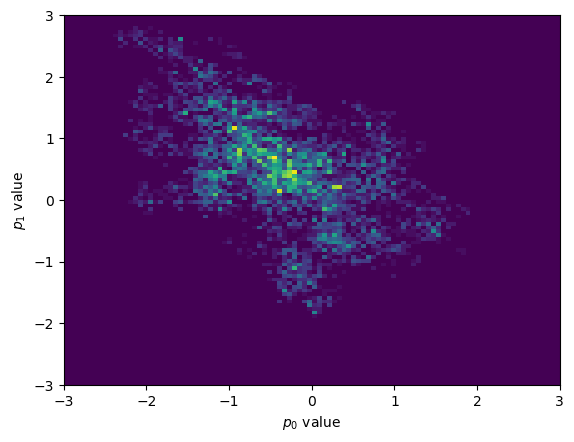

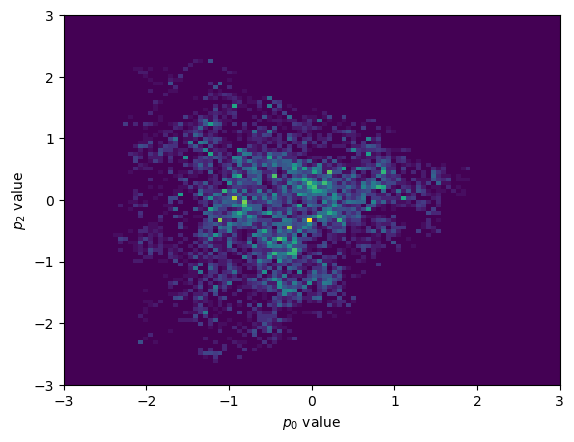

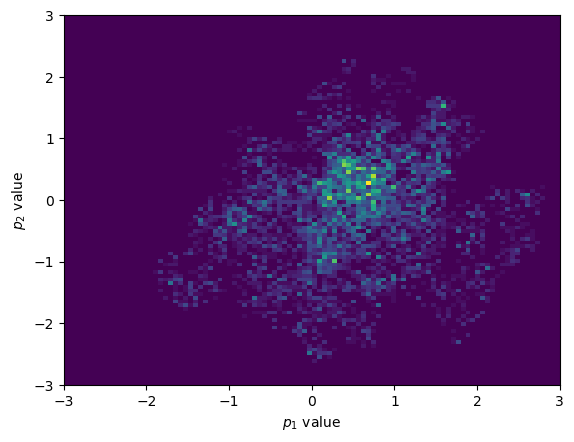

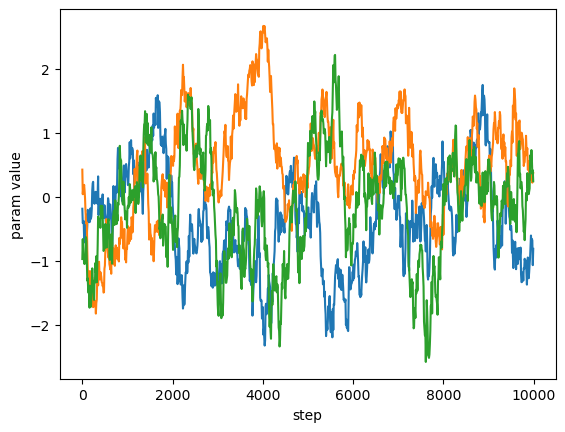

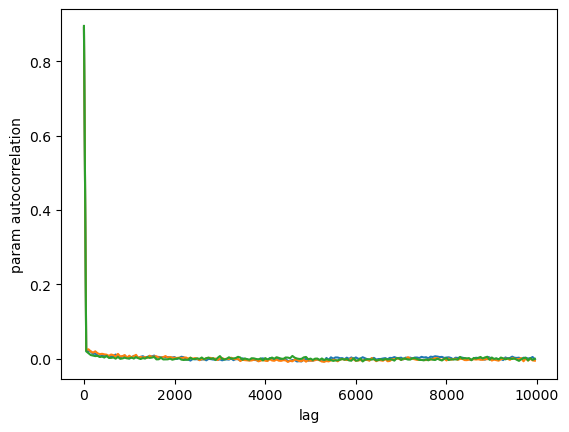

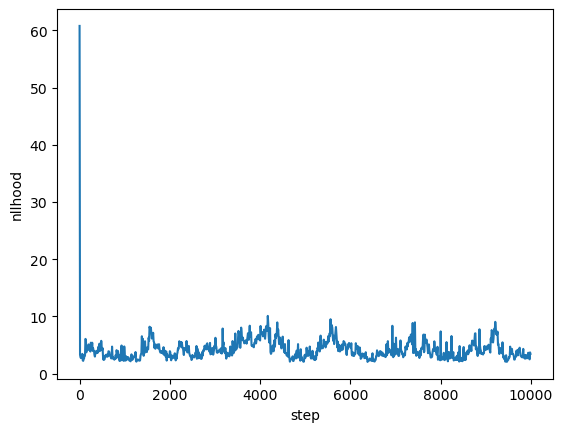

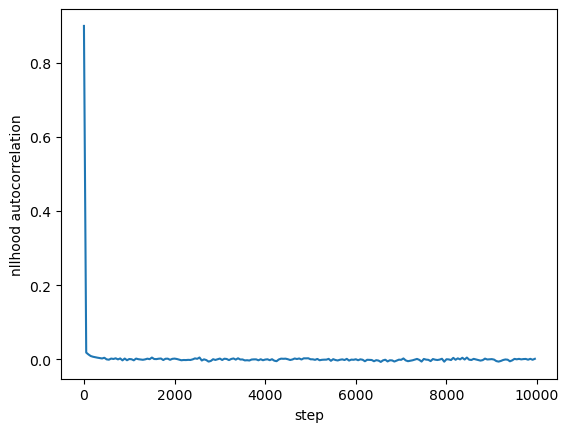

In [69]:
samples.plot_tprob_trace(navg=1000, NSteps=200000)
plt.show()

samples.plot_param2D_post(0, 1,bins=[[-3,3,100],[-3,3,100]])
plt.show()
samples.plot_param2D_post(0, 2,bins=[[-3,3,100],[-3,3,100]])
plt.show()
samples.plot_param2D_post(1, 2,bins=[[-3,3,100],[-3,3,100]])
plt.show()

for i in range(3):
    samples.plot_param_trace(i, nskip=10)
plt.ylabel("param value")
plt.xlabel("step")
plt.show()

for i in range(3):
    samples.plot_param_acf(i,stop=10000, step=50)
plt.ylabel("param autocorrelation")
plt.xlabel("lag")
plt.show()

samples.plot_llh_trace(nskip=10)
plt.ylabel("nllhood")
plt.xlabel("step")
plt.show()

samples.plot_llh_acf(stop=10000,step=50)
plt.ylabel("nllhood autocorrelation")
plt.xlabel("step")
plt.show()

# Real Attempt

In [70]:
%%time

samples, proposer = metropolis_hastings(fnllh=myana.nllh, 
                             initial_state=np.random.normal(1,0.15, myana.nsyst),
                             num_samples=200000,
                             stepsize=0.01,
                             update_ntimes=5, update_every=10000)

processed 10000 steps in 32s (3.2 ms/st) with avg. acceptance prob: 0.78
	Updated proposer covariance
processed 10000 steps in 33s (3.3 ms/st) with avg. acceptance prob: 0.3
	Updated proposer covariance
processed 10000 steps in 35s (3.5 ms/st) with avg. acceptance prob: 0.26
	Updated proposer covariance
processed 10000 steps in 37s (3.7 ms/st) with avg. acceptance prob: 0.26
	Updated proposer covariance
processed 10000 steps in 35s (3.5 ms/st) with avg. acceptance prob: 0.25
	Updated proposer covariance
processed 10000 steps in 34s (3.4 ms/st) with avg. acceptance prob: 0.24
processed 10000 steps in 32s (3.2 ms/st) with avg. acceptance prob: 0.25
processed 10000 steps in 34s (3.4 ms/st) with avg. acceptance prob: 0.25
processed 10000 steps in 33s (3.3 ms/st) with avg. acceptance prob: 0.25
processed 10000 steps in 33s (3.3 ms/st) with avg. acceptance prob: 0.26
processed 10000 steps in 33s (3.3 ms/st) with avg. acceptance prob: 0.25
processed 10000 steps in 33s (3.3 ms/st) with avg. ac

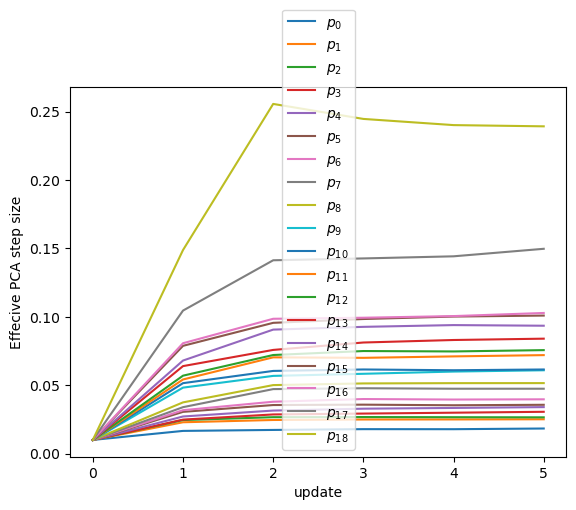

In [71]:
proposer.plot_step_sizes()

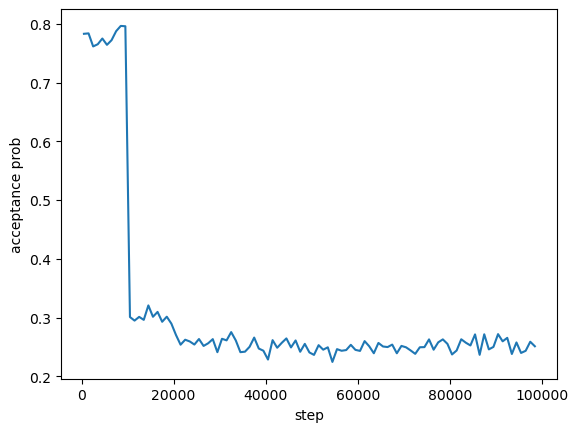

In [72]:
samples.plot_tprob_trace(navg=1000, NSteps=100000)
plt.ylabel("acceptance prob")
plt.xlabel("step")
plt.show()

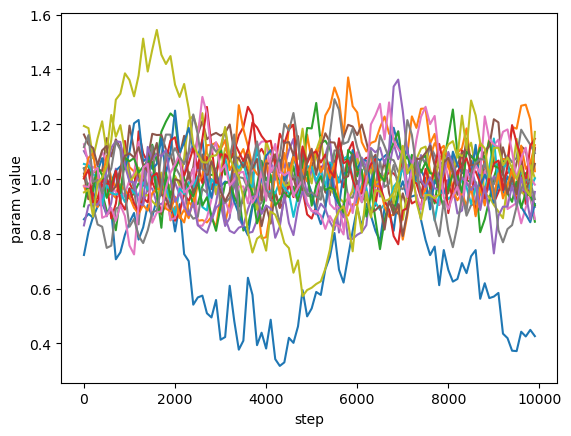

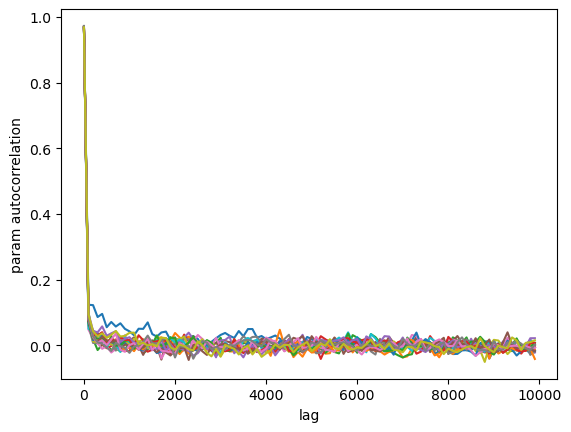

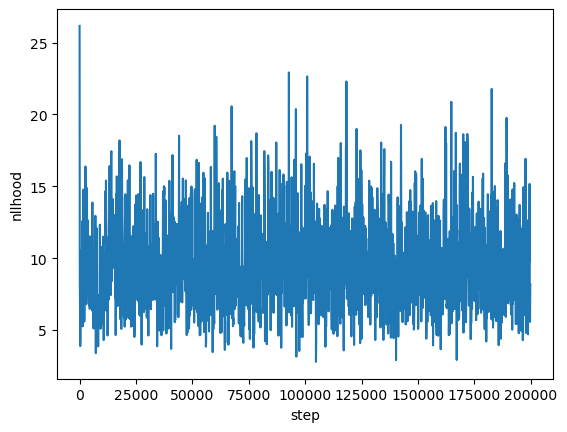

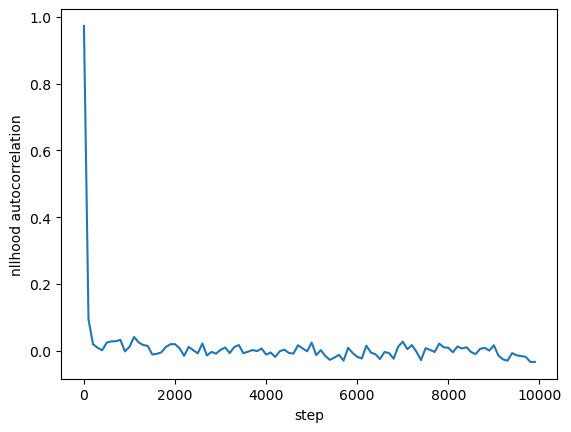

In [73]:
for i in range(myana.nsyst):
    samples.plot_param_trace(i, NSteps=200000, nskip=100)
plt.ylabel("param value")
plt.xlabel("step")
plt.show()

for i in range(myana.nsyst):
    samples.plot_param_acf(i, stop=10000, step=100)
plt.ylabel("param autocorrelation")
plt.xlabel("lag")
plt.show()

samples.plot_llh_trace(NSteps=200000, nskip=100)
plt.ylabel("nllhood")
plt.xlabel("step")
plt.show()

samples.plot_llh_acf(stop=10000, step=100)
plt.ylabel("nllhood autocorrelation")
plt.xlabel("step")
plt.show()

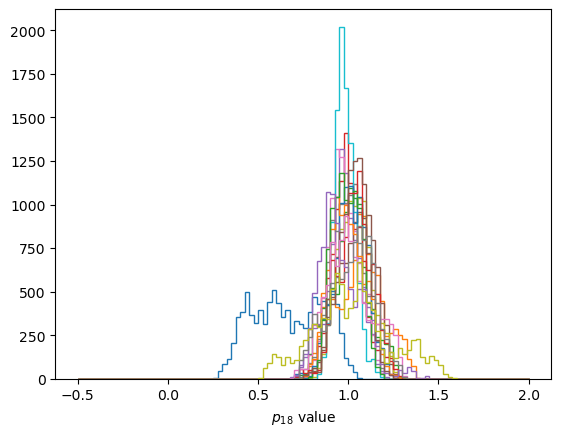

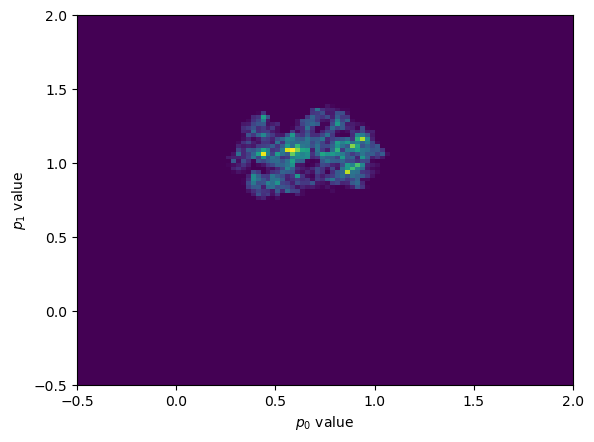

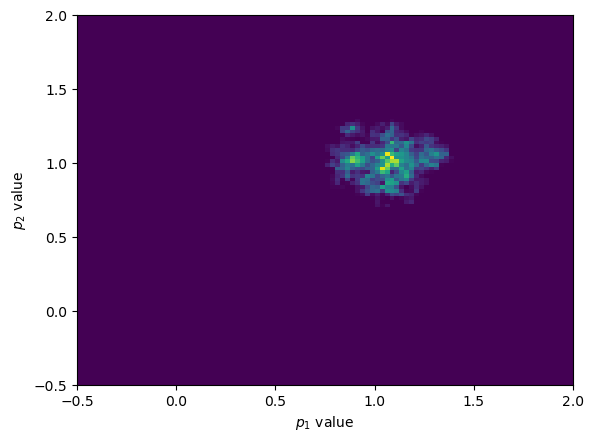

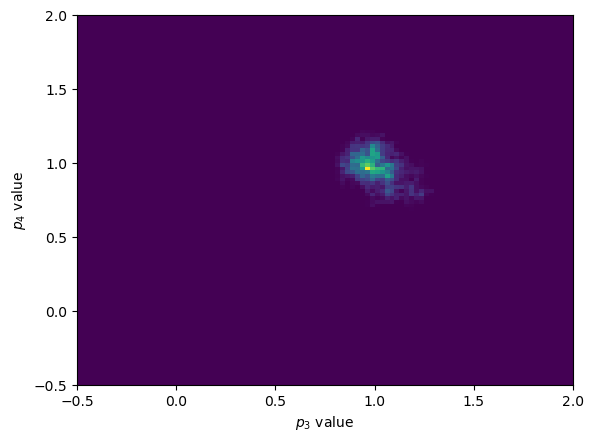

In [74]:
for i in range(myana.nsyst):
    samples.plot_param_post(i, bins=[-0.5,2,100])
plt.show()

samples.plot_param2D_post(0, 1,bins=[[-0.5,2,100],[-0.5,2,100]])
plt.show()
samples.plot_param2D_post(1, 2,bins=[[-0.5,2,100],[-0.5,2,100]])
plt.show()
samples.plot_param2D_post(3, 4,bins=[[-0.5,2,100],[-0.5,2,100]])
plt.show()